Let's build a neural network from scratch to recognize handwritten digits. We will only use nummpy for loading and preprocessing
the data. 
Everything else will be in python, written to be as clear as possible

Part 1 is setting up your imports, and getting and loading the MNIST dataset

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
print("Fetching the MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target
print("MNIST dataset loaded")

Fetching the MNIST dataset...
MNIST dataset loaded


In [3]:
#Splitting the data into train, validation and test sets
#We'll first split into training and testing in a 7:3 ratio
#We'll then split the test data into testing and validation in a 2:1 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33)

In [4]:
print("Dataset shapes:")
print(f"Training (X_train and y_train): {X_train.shape}, {y_train.shape}")
print(f"Validation (X_val and y_val):{X_val.shape}, {y_val.shape}")
print(f"Test (X_test, y_test): {X_test.shape}, {y_test.shape}")

Dataset shapes:
Training (X_train and y_train): (49000, 784), (49000,)
Validation (X_val and y_val):(6930, 784), (6930,)
Test (X_test, y_test): (14070, 784), (14070,)


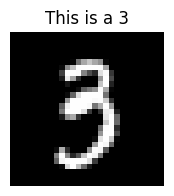

In [5]:
#Let's look at a few digits to make sure the data looks right

def view_digit(index):
    """Show a digit along  with the label"""
    plt.figure(figsize=(2,2))
    plt.imshow(X_train[index].reshape(28,28), cmap='gray')
    plt.title(f"This is a {y_train[index]}")
    plt.axis("off")
    plt.show

#Look at a random digit
random_index = random.randint(0, len(X_train)-1)
view_digit(random_index)

Part 2

This will be the last part where we'll use numpy. Here, we will convert the labels from numbers to vectors:
For example, the label 5 would become [0,0,0,0,0,1,0,0,0,0]

Why? Well, when we are training a neural network to output the predictions for a random single digit image, you can code the output 3 ways:
1. The number itself. You'd want to train the network to output 5 for an image saying 5. This isn't a good idea. Let me illustrate with an example. Let's say you have an image that should be a 4. But the network thinks it's a 5. In which case, the error(how far your prediction is from the actual) would be 1. If the network predicts it to be 9 instead, you've got a larger error, which is 4. This won't do. "4" isn't more similar to "5" than "9" is. They're all just different digits. We want all numbers to be "equidistant" from each other - error wise.
2. Binary output. This also faces a similar issue. To encode 0 to 9, you'd need 4 binary digits for each number. 6 would be [0,1,1,0] and 7 would be [0,1,1,1] and 8 would be [1,0,0,0]. To go from 7 to 8, you'd have to FLIP all the bits, whereas to go from 6 to 7, you'd only have to flip 1 bit. This again creates a false relationship where 6 is "closer" to 7 than 7 is to 8.
3. The final option is to have 10 output digits. This is called one hot encoding. 1 would be [0,1,0,0,0,0,0,0,0,0] and 9 would be [[0,0,0,0,0,0,0,0,0,1]]. Every digit is only "2 flips" away from any other digit. There are no implied relationships. Error calculations are also easy. 

In [6]:
def one_hot_encoding(labels, num_classes = 10):
    #Convert number labels to one hot encoded vectors
    encoded = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        encoded[i][int(label)] = 1
    return encoded

#Convert all our labels
y_train_encoded = one_hot_encoding(y_train)
y_val_encoded = one_hot_encoding(y_val)
y_test_encoded = one_hot_encoding(y_test)

In [7]:
#Check if it worked
print("First few labels before and after encoding:")
print("Before:", y_train[:3])
print("After:", y_train_encoded[:3])

First few labels before and after encoding:
Before: ['9' '9' '8']
After: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


Part 3 - No more numpy. All my homies love numpy.

In [8]:
class My_Neural_Network:
    def __init__(self, layer_sizes):
        """
        We are creating a neural network to take an image input and pass a number output.
        We know that the image is 28*28 pixels while the output is a 1d array with 10 binary elements.
        
        Let's do 784 input --> 112 neurons in the first hidden layer --> 16 in the second hidden layer and 10 in the output layer
        Then it would be My_Neural_Network[784,112,16,10]
        """
        self.sizes = layer_sizes
        self.num_layers = len(layer_sizes)

        #Initialize random weights and 1 bias
        self.weights = []
        self.biases = []
        
        #For each layer (except the input layer), let's create some weights and biases
        for i in range(len(self.sizes)-1):
            #Create weights b/w the current layer and the next layer
            layer_weights = []
            for destination_neuron in range(self.sizes[i+1]):
                neuron_weights = []
                for source_neuron in range(self.sizes[i]):
                    #Random weight b/w -0.5 and 0.5
                    weight = (random.random() - 0.5)
                    neuron_weights.append(weight)
                layer_weights.append(neuron_weights)
            self.weights.append(layer_weights)
        
            #Create 1 biases for next layer
            layer_biases = [1.0 for _ in range(self.sizes[i+1])]
            self.biases.append(layer_biases)

    def sigmoid(self, x):
        #This will be our activation function --> for any given input, it will only output a number b/w 0 and 1
        if x < -700:
            return 0.0
        elif x > 700:
            return 1.0
        
        return 1.0/(1.0 + math.exp(-x))
    
    def sigmoid_derivative(self, x):
        #This is the derivative of a sigmoid.
        return self.sigmoid(x)*(1-self.sigmoid(x))
    
    def feedforward(self, inputs):
        """
        Push data through the network to get predictions. It returns:
        1. Actvations --> neuron outputs at each layer
        2. weighted sums --> sigmoid(weighted_sums) = activations from the previous step (We'll use this for backpropagation)
        """

        #Leep track of values we need for backpropagation
        current_values = inputs
        all_activations = [inputs] #We'll put this as the input for now. It'll get updated every layer
        all_weighted_sums = []

        #Go through each layer
        for layer_weights, layer_biases in zip(self.weights, self.biases):

            #The weighted sum is z = w*a + b
            weighted_sums = []
            for weights, bias in zip(layer_weights, layer_biases):
                total = sum(w * a for w,a in zip(weights, current_values))
                weighted_sums.append(total + bias)
            all_weighted_sums.append(weighted_sums)
        
            #Apply the sigmoid function on weighted_sums to get activations
            current_values = [self.sigmoid(z) for z in weighted_sums]
            all_activations.append(current_values)
        
        return all_activations, all_weighted_sums

    def backpropagate(self, training_example, label):
        """
        1. Find out how much the error was
        2. Find out how much each weight and bias contributed to the error
        Return weight and bias gradients for each layer.
        """        

        #Forward pass to get all the values we need for backpropagation
        activations, weighted_sums = self.feedforward(training_example)

        #Initialize gradients as zero
        weight_gradients = [[[0.0 for _ in range(len(w_row))]
                                for w_row in layer]
                                for layer in self.weights]
        bias_gradients = [[0.0 for _ in range(len(b))]
                            for b in self.biases]
        
        #Calculate the error at the output layer
        output_error = [a - t for a, t in zip(activations[-1], label)]
        layer_error = [err * self.sigmoid_derivative(a)
                        for err, a in zip(output_error, activations[-1])]
        
        #Save gradients for output layer
        bias_gradients[-1] = layer_error
        for i, error in enumerate(layer_error):
            for j, activation in enumerate(activations[-2]):
                weight_gradients[-1][i][j] = error * activation
        
        #Backpropagate error through earlier layers
        for layer in range(2, self.num_layers):
            layer_error_new = []

            #For each neuron in current layer
            for j in range(len(self.weights[-layer])):
                #Calculate error based on the next layer's error.
                error = 0.0
                for k in range(len(layer_error)):
                    error += self.weights[-layer+1][k][j] * layer_error[k]
                error *= self.sigmoid_derivative(activations[-layer][j])
                layer_error_new.append(error)
            
            layer_error = layer_error_new

            #Save gradients
            bias_gradients[-layer] = layer_error
            for i, error in enumerate(layer_error):
                for j, activation in enumerate(activations[-layer-1]):
                    layer_index = len(self.weights) - layer
                    weight_gradients[layer_index][i][j] = error * activation
    
        return weight_gradients, bias_gradients
    
    def update_mini_batch(self, mini_batch, learning_rate):
        #Update network weights using a small batch of shuffled training data

        #Initialize gradient sums as zero

        weight_sums = [[[0.0 for _ in range(len(w_row))]
                        for w_row in layer]
                        for layer in self.weights]
        
        bias_sums = [[0.0 for _ in range(len(b))]
                        for b in self.biases]
        
        #Calculate gradients for each training example
        for inputs, label in mini_batch:
            weight_gradients, bias_gradients = self.backpropagate(inputs, label)

            #Add to sums
            for layer in range(len(weight_sums)):
                for i in range(len(weight_sums[layer])):
                    for j in range(len(weight_sums[layer][i])):
                        weight_sums[layer][i][j] += weight_gradients[layer][i][j]
            
            for layer in range(len(bias_sums)):
                for i in range(len(bias_sums[layer])):
                    bias_sums[layer][i] += bias_gradients[layer][i]
        
        # Update weights and biases using average gradients
        batch_size = len(mini_batch)
        for layer in range(len(self.weights)):
            for i in range(len(self.weights[layer])):
                for j in range(len(self.weights[layer][i])):
                    self.weights[layer][i][j] -= (learning_rate/batch_size) * weight_sums[layer][i][j]
            
            for i in range(len(self.biases[layer])):
                self.biases[layer][i] -= (learning_rate/batch_size) * bias_sums[layer][i]
    
    def train(self, training_data, epochs, mini_batch_size, learning_rate):
        #Train the network on batches of data
        n = len(training_data)

        for epoch in range(epochs):
            #Shuffle the training data
            random.shuffle(training_data)

            #Create mini-batches
            mini_batches = [
                training_data[k:k+ mini_batch_size]
                for k in range(0, n , mini_batch_size)
            ]

            #Train on each mini-batch
            print(f" Epoch {epoch + 1}: Training on {len(mini_batches)} batches")
            for i, mini_batch in enumerate(mini_batches):
                if i % 100 == 0:
                    #Show progress every 100 batches
                    print(f" Batch {i}/{len(mini_batches)}")
                self.update_mini_batch(mini_batch, learning_rate)
            
            #Calculate and show accuracy
            accuracy = self.evaluate(validation_data)
            print(f"Epoch {epoch+1}: {accuracy:.2f}% accuracy")
        
    def predict(self, inputs):
        #Get network's prediction (0-9) for an input
        activations, _ = self.feedforward(inputs)
        output = activations[-1]
        return output.index(max(output))
    
    def evaluate(self, test_data):
        #Calcuate accuracy on test data
        correct = 0
        total = len(test_data)

        for inputs, label in test_data:
            prediction = self.predict(inputs)
            actual = list(label).index(1) 
            #We are bringing the label back from one-hot-encoded to a numeric form
            if prediction == actual:
                correct += 1
        
        return (correct/total)*100 
            
#And that's it. 200 lines of code for a neural network in python

# First, convert numpy arrays to lists and normalize
X_train_list = [list(x/255.0) for x in X_train]
X_val_list = [list(x/255.0) for x in X_val]
X_test_list = [list(x/255.0) for x in X_test]

# Create training data pairs
training_data = list(zip(X_train_list, y_train_encoded))
validation_data = list(zip(X_val_list, y_val_encoded))
test_data = list(zip(X_test_list, y_test_encoded))

# Create and train network
print("\nCreating neural network...")
network = My_Neural_Network([784, 112, 16, 10])

print("\nStarting training...")
network.train(
    training_data,
    epochs=10,
    mini_batch_size=32,
    learning_rate=0.5
)


Creating neural network...

Starting training...
 Epoch 1: Training on 1532 batches
 Batch 0/1532
 Batch 100/1532
 Batch 200/1532
 Batch 300/1532
 Batch 400/1532
 Batch 500/1532
 Batch 600/1532
 Batch 700/1532
 Batch 800/1532
 Batch 900/1532
 Batch 1000/1532
 Batch 1100/1532
 Batch 1200/1532
 Batch 1300/1532
 Batch 1400/1532
 Batch 1500/1532
Epoch 1: 69.19% accuracy
 Epoch 2: Training on 1532 batches
 Batch 0/1532
 Batch 100/1532
 Batch 200/1532
 Batch 300/1532
 Batch 400/1532
 Batch 500/1532
 Batch 600/1532
 Batch 700/1532
 Batch 800/1532
 Batch 900/1532
 Batch 1000/1532
 Batch 1100/1532
 Batch 1200/1532
 Batch 1300/1532
 Batch 1400/1532
 Batch 1500/1532
Epoch 2: 72.15% accuracy
 Epoch 3: Training on 1532 batches
 Batch 0/1532
 Batch 100/1532
 Batch 200/1532
 Batch 300/1532
 Batch 400/1532
 Batch 500/1532
 Batch 600/1532
 Batch 700/1532
 Batch 800/1532
 Batch 900/1532
 Batch 1000/1532
 Batch 1100/1532
 Batch 1200/1532
 Batch 1300/1532
 Batch 1400/1532
 Batch 1500/1532
Epoch 3: 74.94%

PS: This is an amazing resource that really helped me understand backprop in detail -- https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/ 



In [9]:
import json

def export_weights():
    # Convert nested lists to format suitable for JSON
    weights_json = []
    for layer in network.weights:
        layer_weights = []
        for neuron in layer:
            layer_weights.append(neuron)
        weights_json.append(layer_weights)
    
    biases_json = []
    for layer in network.biases:
        layer_biases = []
        for bias in layer:
            layer_biases.append(float(bias))  # Convert to float for JSON serialization
        biases_json.append(layer_biases)
    
    model_data = {
        'weights': weights_json,
        'biases': biases_json
    }
    
    with open('mnist_weights.json', 'w') as f:
        json.dump(model_data, f)

# Call this after training
export_weights()

In [10]:
test_accuracy = network.evaluate(test_data)
print(f"\nFinal test set accuracy: {test_accuracy:.2f}%")


Final test set accuracy: 76.34%
